# Data Analysis Skill Test - 4Intelligence

*   Diego Rosa | 08/07/2020

##  Case 1 - TFP

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [3]:
tfp_df = pd.read_csv('TFP.csv')

In [4]:
tfp_df.head()

isocode  year    rtfpna
0     USA  1950  0.617148
1     USA  1951  0.629588
2     USA  1952  0.638451
3     USA  1953  0.651858
4     USA  1954  0.646179

In [5]:
#checking missing values
tfp_df.isnull().sum()

isocode    0
year       0
rtfpna     0
dtype: int64

In [6]:
#how many entries per country (isocode)
tfp_df.groupby('isocode')['year'].count()

isocode
CAN    62
MEX    62
USA    62
Name: year, dtype: int64

In [7]:
# convert feature year into datetime format
tfp_df['year'] = pd.to_datetime(tfp_df['year'], format="%Y")
# use year as df index
tfp_df.index = tfp_df['year']
# feature year is no longer necessary as time information is contained into the index
tfp_df.drop('year', inplace=True, axis=1)

In [459]:
tfp_df.head()

isocode    rtfpna
year                        
1950-01-01     USA  0.617148
1951-01-01     USA  0.629588
1952-01-01     USA  0.638451
1953-01-01     USA  0.651858
1954-01-01     USA  0.646179

In [9]:
# splitting data per country - one time series per country
tfp_usa_df = tfp_df[tfp_df['isocode'] == 'USA'].drop(columns='isocode')
tfp_mex_df = tfp_df[tfp_df['isocode'] == 'MEX'].drop(columns='isocode')
tfp_can_df = tfp_df[tfp_df['isocode'] == 'CAN'].drop(columns='isocode')

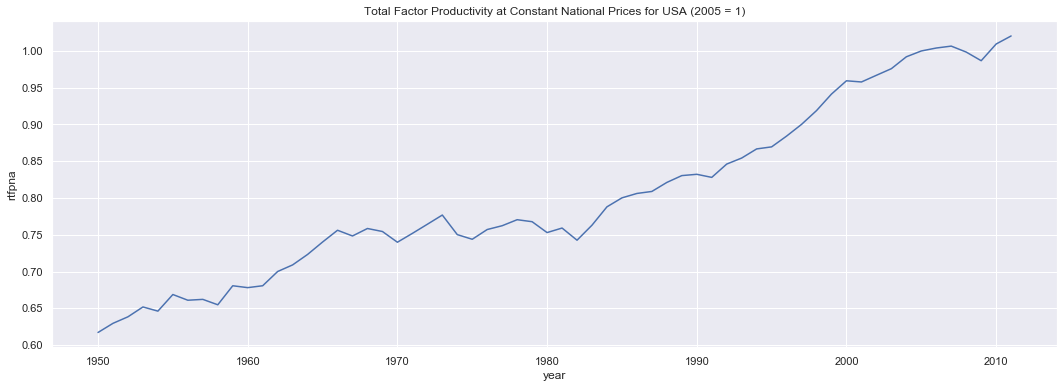

In [10]:
# Plot TFP - USA

sns.set()
plt.figure(figsize = (18,6));
plt.title('Total Factor Productivity at Constant National Prices for USA (2005 = 1)')
ax = sns.lineplot(x=tfp_usa_df.index, y=tfp_usa_df['rtfpna'])

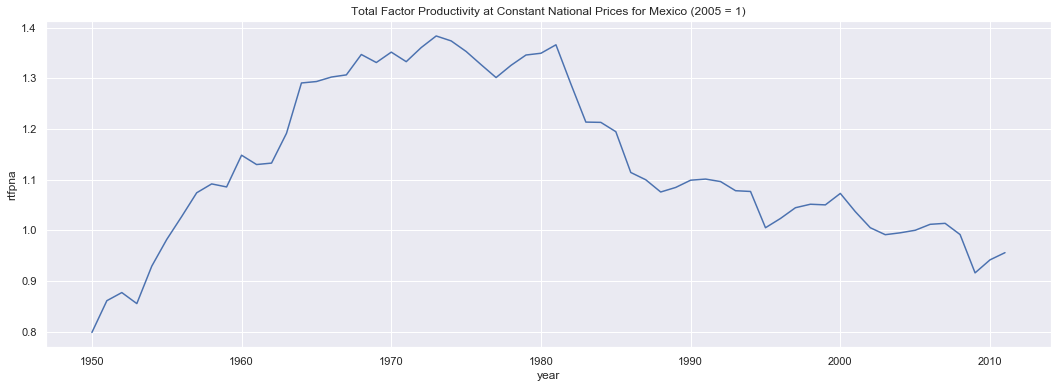

In [11]:
# Plot TFP - Mexico

plt.figure(figsize = (18,6));
plt.title('Total Factor Productivity at Constant National Prices for Mexico (2005 = 1)')
ax = sns.lineplot(x=tfp_mex_df.index, y=tfp_mex_df['rtfpna'])

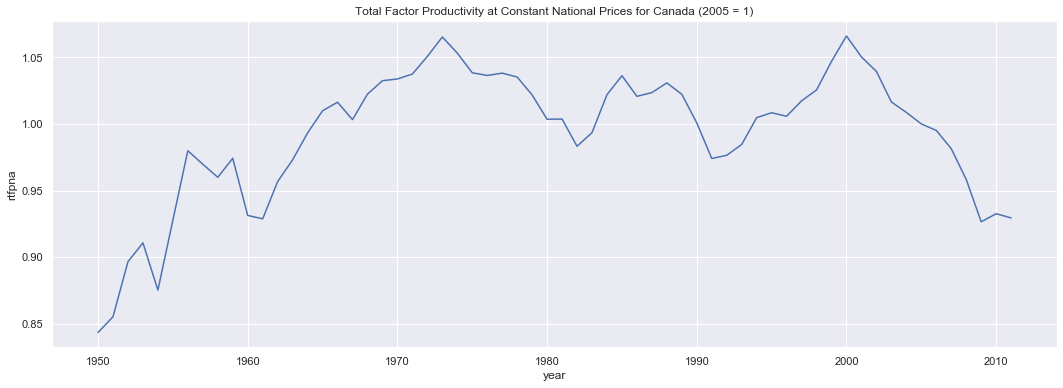

In [12]:
# Plot TFP - Canada

plt.figure(figsize = (18,6));
plt.title('Total Factor Productivity at Constant National Prices for Canada (2005 = 1)')
ax = sns.lineplot(x=tfp_can_df.index, y=tfp_can_df['rtfpna'])

###  Exploratory Data Analysis (EDA)

####  Decomposing the time series

In [13]:
def decompose_ts(ts):
    '''
    INPUT: time series to be decomposed
    
    OUTPUT: none
    
    This function decomposes the time series into it's components: Trend, Seasonality and Residuals using
    the seasonal_decomposing functions from statsmodels.tsa and plot it
    
    '''
    decomposed_ts = seasonal_decompose(ts)
    #plot the ts components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(16,8))
    decomposed_ts.observed.plot(ax=ax1)
    decomposed_ts.trend.plot(ax=ax2)
    decomposed_ts.seasonal.plot(ax=ax3)
    decomposed_ts.resid.plot(ax=ax4)

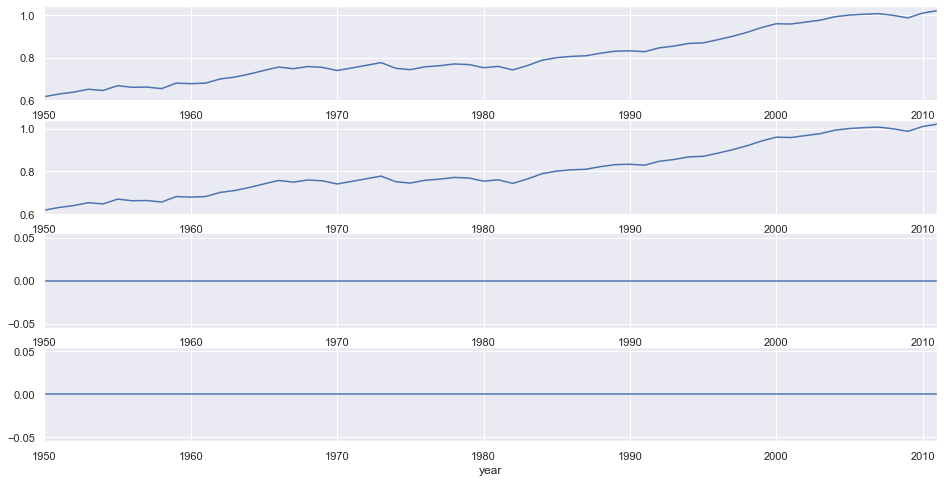

In [14]:
# Decompose USA Total Factor Productivity
decompose_ts(tfp_usa_df['rtfpna'])

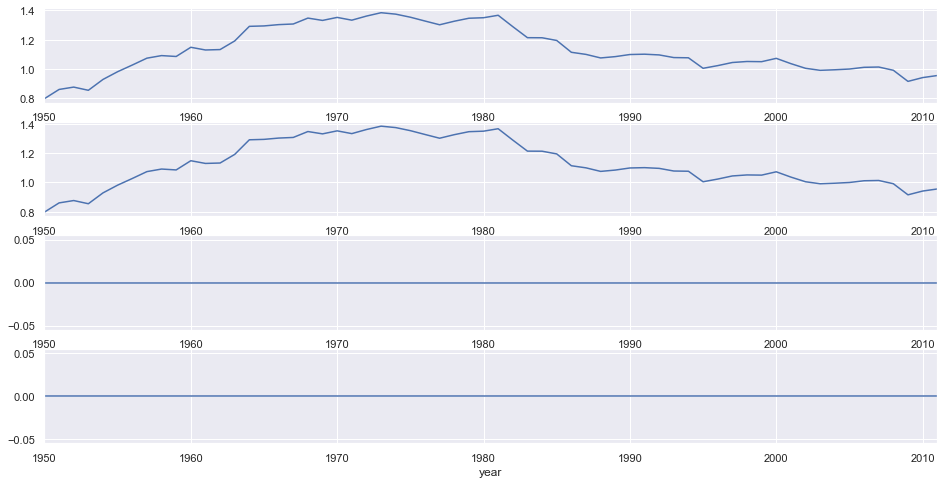

In [15]:
# Decompose Mexico Total Factor Productivity
decompose_ts(tfp_mex_df['rtfpna'])

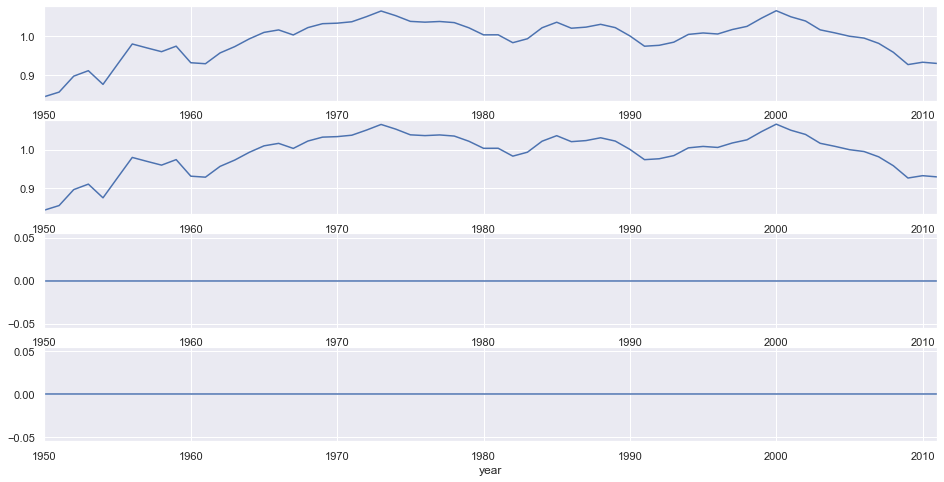

In [16]:
# Decompose Canada Total Factor Productivity
decompose_ts(tfp_can_df['rtfpna'])

*   For all the tree time series, all the characteristics where entirelt captured into the trend - There is no seasonality, neither residuals;


####  Checking Stationarity

*   Visually checking rolling statistics to create intuition regarding stationarity - I'll use a window of 10 years

In [17]:
def rolling_statistics(ts, window_size):
    '''
    INPUT - time series (ts) and window size for the rolling statistic (window_size);
    
    OUTPUT -  rolling mean (r_mean), rolling standard deviation (r_std);
    
    '''
    r_mean = ts.rolling(window=window_size).mean()
    r_std = ts.rolling(window=window_size).std()
    
    return r_mean, r_std
    

In [1]:
def plot_rolling_stats(ts, r_mean, r_std, iso_code):
    '''
    INPUT - time series, rolling mean, rolling standard deviation, country iso_code
    
    OUTPUT - None
    
    This function plots together the original time series data, it's rolling mean and it's rolling deviation
    
    '''
    plt.figure(figsize = (16,5));
    original_ts = plt.plot(ts, color='blue', label = 'Original Data')
    mean = plt.plot(r_mean, color = 'red', label = 'Rolling Mean')
    mean = plt.plot(r_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation - {}'.format(iso_code))
    plt.show(block=False)
    

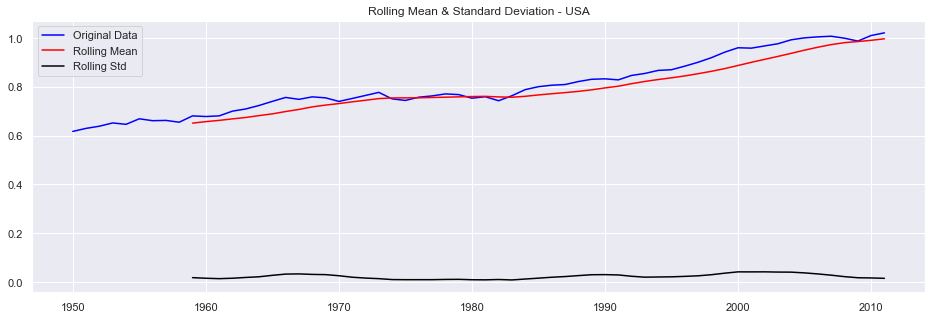

In [19]:
# Rolling Statistics - USA
r_mean, r_std = rolling_statistics(tfp_usa_df['rtfpna'], 10)
plot_rolling_stats(tfp_usa_df['rtfpna'], r_mean, r_std, 'USA')

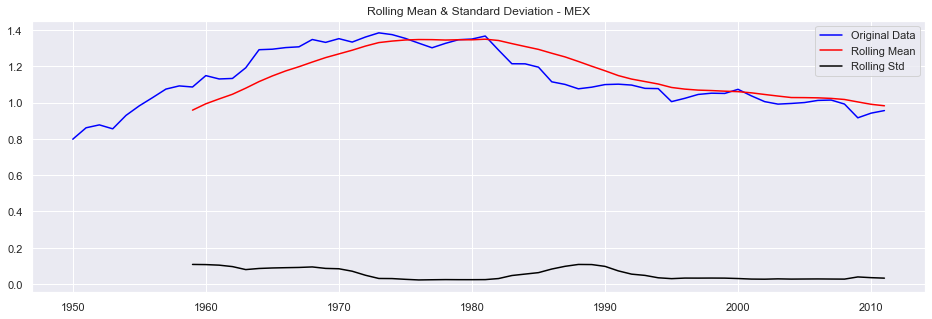

In [20]:
# Rolling Statistics - Mexico
r_mean, r_std = rolling_statistics(tfp_mex_df['rtfpna'], 10)
plot_rolling_stats(tfp_mex_df['rtfpna'], r_mean, r_std, 'MEX')

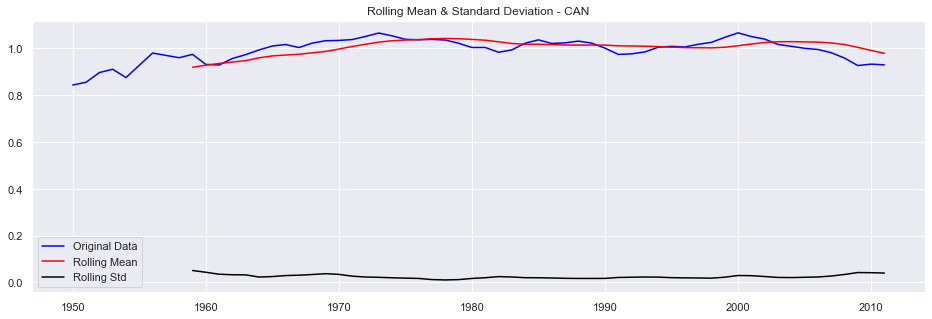

In [21]:
# Rolling Statistics - Canada
r_mean, r_std = rolling_statistics(tfp_can_df['rtfpna'], 10)
plot_rolling_stats(tfp_can_df['rtfpna'], r_mean, r_std, 'CAN')

*   **USA**:
    *   The rolling mean (using a 10 years window period) shows itself a positive trend, while rolling standard deviation kept quite constant. The positive trend observed into the original data and on the rolling mean, has it's slope significantly increased on the 90's decade - which is when computers and the internet started to be used, and it's a good hypothesis to explain the growth on the USA's productivity;
    *   Doesn't look stationary;
*   **Mexico**:
    *   Here we have the same case as described above: the rolloing mean has a tren itself, while rolling standard deviation was kept white constant. However, instead of a positive trend, Mexico had a increasing FTP, which have peaked in the 70s, and since then the slope is negative
    *   This time series also don't look sttionary;
*   **Canada**
    *   Canada data is the best candidate for stationarity among the three time series. Both rolling mean and standard deviation look quite constant over time;

*   Using Augmented Dickey-Fuller test to check stationarity:

In [40]:
def adfuller_test(ts):
    '''
    INPUT - time series to be analyzed
    
    OUTPUTS - none
    
    This function applies the Augmented Dickey Fuller (from statsmodels.tsa) test to check the inputed time series stationarity
    and print the results. If p-value less or equal to 0.05, null hypothesis is rejected;
    
    H0 (Null Hypothesis) - Time serie is not stationary;
    H1 (Alternative Hypothesis) - Time serie is stationary;
    
    '''
    adf_result = adfuller(ts)
    print('Augmented Dickey Fuller Test')
    print('Statistic Test: {:.4f}'.format(adf_result[0]))
    print('P-value: {:.4f}'.format(adf_result[1]))
    print('Critical Values:')
    for key,value in adf_result[4].items():
        print('\t {}: {:.4f}'.format(key, value))
    print('\nTest Result:')
    if adf_result[1] <= 0.05:
        print('Null hypothesis has been rejected - The time serie is stationary')
    else:
        print('Not enough evidence to reject the null hypothesis - Cannot confirm the time serie´s stationarity.')


In [42]:
# ADF Test on USA data:
adfuller_test(tfp_usa_df['rtfpna'].values)

Augmented Dickey Fuller Test
Statistic Test: 0.2236
P-value: 0.9736
Critical Values:
	 1%: -3.5424
	 5%: -2.9102
	 10%: -2.5927

Test Result:
Not enough evidence to reject the null hypothesis - Cannot confirm the time serie´s stationarity.


In [43]:
# ADF Test on Mexico data:
adfuller_test(tfp_mex_df['rtfpna'].values)

Augmented Dickey Fuller Test
Statistic Test: -1.9404
P-value: 0.3133
Critical Values:
	 1%: -3.5629
	 5%: -2.9190
	 10%: -2.5974

Test Result:
Not enough evidence to reject the null hypothesis - Cannot confirm the time serie´s stationarity.


In [44]:
# ADF Test on Canada data:
adfuller_test(tfp_can_df['rtfpna'].values)

Augmented Dickey Fuller Test
Statistic Test: -3.0278
P-value: 0.0324
Critical Values:
	 1%: -3.5444
	 5%: -2.9111
	 10%: -2.5932

Test Result:
Null hypothesis has been rejected - The time serie is stationary


*   The Augmented Dickey Fuller tests were exactly what we expected from the intuition built from the rolling statistics plots. Only Canada data is stationary (p-value is small enough, and the critical values are pretty close to the test statistics;
*   It means that it will be necessary to apply some transformation into USA and Mexico data before working on the prediction model;

##### Data Transformation - USA Data

The goal here is to remove the trend from the USA dataset. One good way to start is trying to apply a log transformation, and then subtract the moving average:

*   Log transformation +  Moving Average Subtraction

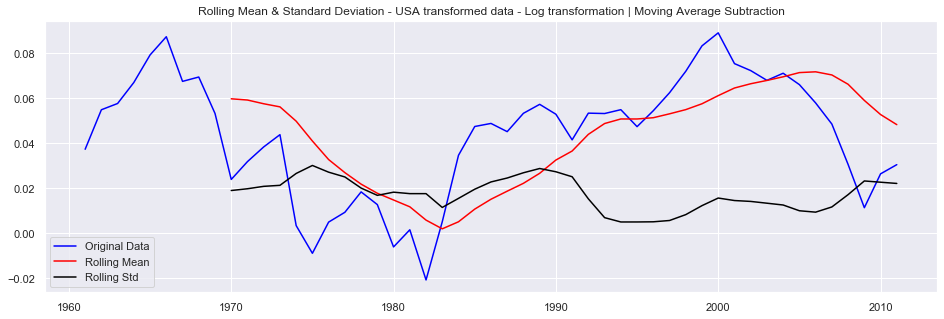

Augmented Dickey Fuller Test
Statistic Test: -2.1466
P-value: 0.2262
Critical Values:
	 1%: -3.5715
	 5%: -2.9226
	 10%: -2.5993

Test Result:
Not enough evidence to reject the null hypothesis - Cannot confirm the time serie´s stationarity.


In [102]:
tfp_usa_df_lma = np.log(tfp_usa_df)
ma = (tfp_usa_df.rolling(12).mean()).dropna()
ma_log = np.log(ma)
tfp_usa_df_lma = (log_df-ma_log).dropna()
r_mean, r_std = rolling_statistics(tfp_usa_df_lma['rtfpna'], 10)
plot_rolling_stats(tfp_usa_df_lma, r_mean, r_std, 'USA transformed data - Log transformation | Moving Average Subtraction')
# ADF Test on transformed USA data:
adfuller_test(tfp_usa_df_lma['rtfpna'].values)


As we can see above, this transformations were not enough for stationarity according to the adopted criteria (Dickey FUller Test).
Hence, one shall try another kind of transformation:

*   **Time-Shift Transformation**

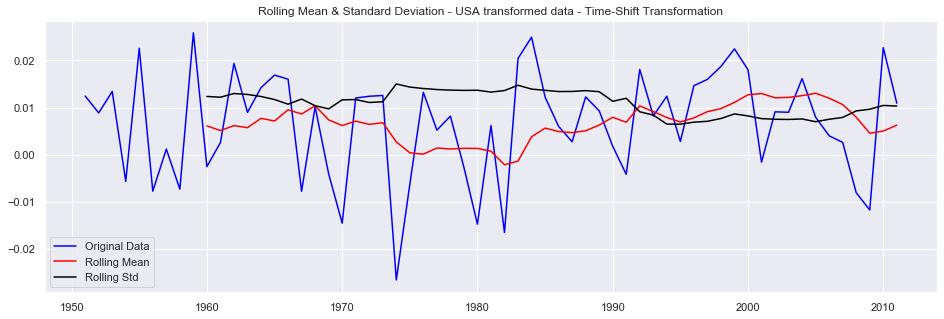

Augmented Dickey Fuller Test
Statistic Test: -7.3847
P-value: 0.0000
Critical Values:
	 1%: -3.5444
	 5%: -2.9111
	 10%: -2.5932

Test Result:
Null hypothesis has been rejected - The time serie is stationary


In [110]:
#Apply time-shift transformation
tfp_usa_df_ts = ((tfp_usa_df) - (tfp_usa_df).shift()).dropna()
#Calculate and plot rolling statistics
r_mean, r_std = rolling_statistics(tfp_usa_df_ts['rtfpna'], 10)
plot_rolling_stats(tfp_usa_df_ts, r_mean, r_std, 'USA transformed data - Time-Shift Transformation')
# ADF Test on Mexico data:
adfuller_test(tfp_usa_df_ts['rtfpna'].values)

Time-shift transformation worked well according to the Augmented Dickey Fuller Test. I'm going to keep this transformation for the USA data.

##### Data Transformation - Mexico Data

For the Mexican dataset, we're also looking for trend removal. However, the trend shape is quite different than it was on the American's dataset. So, I'm going to try exponential decay transformation as my first guess, with a halflife of 10 years;

*   **Exponential Decay**

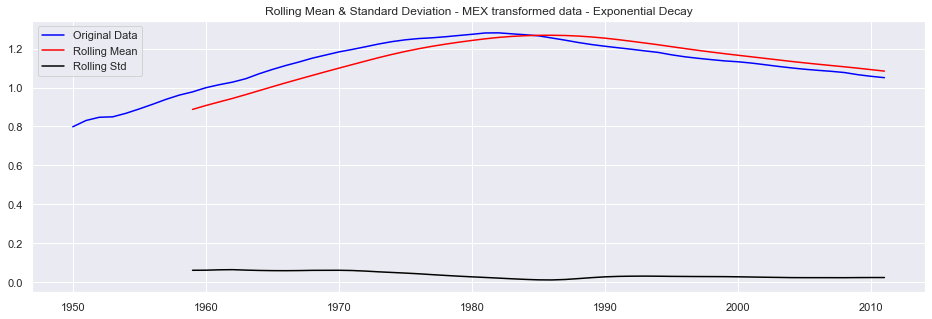

Augmented Dickey Fuller Test
Statistic Test: -2.8759
P-value: 0.0482
Critical Values:
	 1%: -3.5553
	 5%: -2.9157
	 10%: -2.5957

Test Result:
Null hypothesis has been rejected - The time serie is stationary


In [107]:
tfp_mex_df_exp = tfp_mex_df.ewm(halflife=10, min_periods=0, adjust=True).mean()
r_mean, r_std = rolling_statistics(tfp_mex_df_exp['rtfpna'], 10)
plot_rolling_stats(tfp_mex_df_exp, r_mean, r_std, 'MEX transformed data - Exponential Decay')
# ADF Test on Mexico data:
adfuller_test(tfp_mex_df_exp['rtfpna'].values)


This transformation worked well, as the ADF result p-value is small enough to reject the null hypothesis. I'm going also to try Time-Shift Transformation on the Mexican data, to check if it's possible to keep the same transformation method to both datasets:

*   **Time Shift Transformation**

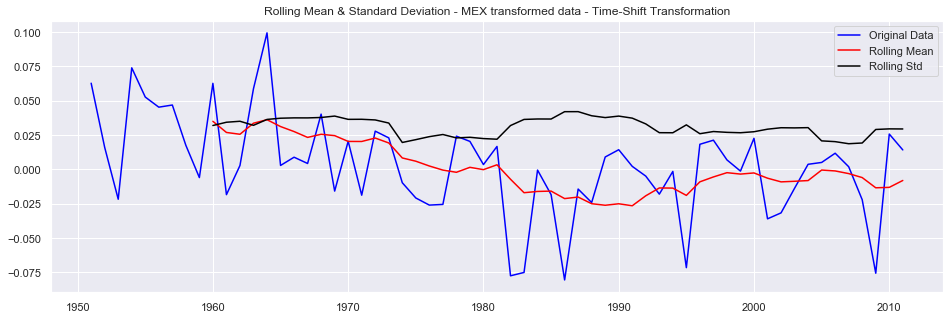

Augmented Dickey Fuller Test
Statistic Test: -5.9548
P-value: 0.0000
Critical Values:
	 1%: -3.5444
	 5%: -2.9111
	 10%: -2.5932

Test Result:
Null hypothesis has been rejected - The time serie is stationary


In [111]:
tfp_mex_df_ts = ((tfp_mex_df) - (tfp_mex_df).shift()).dropna()
r_mean, r_std = rolling_statistics(tfp_mex_df_ts['rtfpna'], 10)
plot_rolling_stats(tfp_mex_df_ts, r_mean, r_std, 'MEX transformed data - Time-Shift Transformation')
# ADF Test on Mexico data:
adfuller_test(df_timeshift['rtfpna'].values)

Time-shift also worked for the mexican dataset. Hence I'm going to use this transformation, in order to have the same method for both USA and MEX data;

### Auto Correlation and Partial Auto Correlation (ACF and PACF)

In [134]:
def calculate_acf_pacf(ts, n_lags):
    '''
    INPUT - time series (ts), number of lags for the acf and pacf function
    
    OUTPUT - Partial Auto Correlation, Auto Correlation and critical value
    
    This function calculates acf and pacf using statsmodels.tsa functions for a given time series
    
    '''
    lag_acf = acf(ts, nlags=n_lags)
    lag_pacf = pacf(ts,nlags=n_lags )
    crit_value = (1.96/np.sqrt(len(ts) - 1))
    return lag_acf, lag_pacf, crit_value

In [151]:
def plot_acf_pacf(lag_acf, lag_pacf,crit_value):
    '''
    INPUT - autocorrelation, partial autocorrelation, critical value
    
    OUTPUT - none
    
    This function plots both acf and pacf in a 1x2 grid image
    
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    plt.subplot(121)
    plt.plot(lag_acf);
    plt.axhline(y=0, linestyle='--', color='gray');
    plt.axhline(y=crit_value, linestyle='--', color='red');
    plt.axhline(y=-crit_value, linestyle='--', color='red');
    plt.title('Autocorrelation Function')
    
    plt.subplot(122)
    plt.plot(lag_pacf);
    plt.axhline(y=0, linestyle='--', color='gray');
    plt.axhline(y=crit_value, linestyle='--', color='red');
    plt.axhline(y=-crit_value, linestyle='--', color='red');
    plt.title('Partial Autocorrelation Function')
    
    
    
    

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


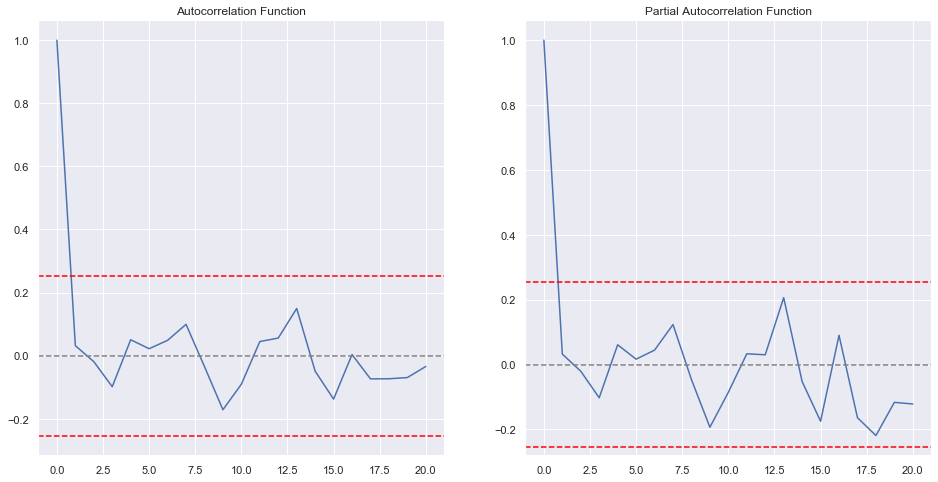

In [161]:
# USA Data
lag_acf, lag_pacf, crit_value = calculate_acf_pacf(tfp_usa_df_ts, 20)
plot_acf_pacf(lag_acf, lag_pacf,crit_value)


C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


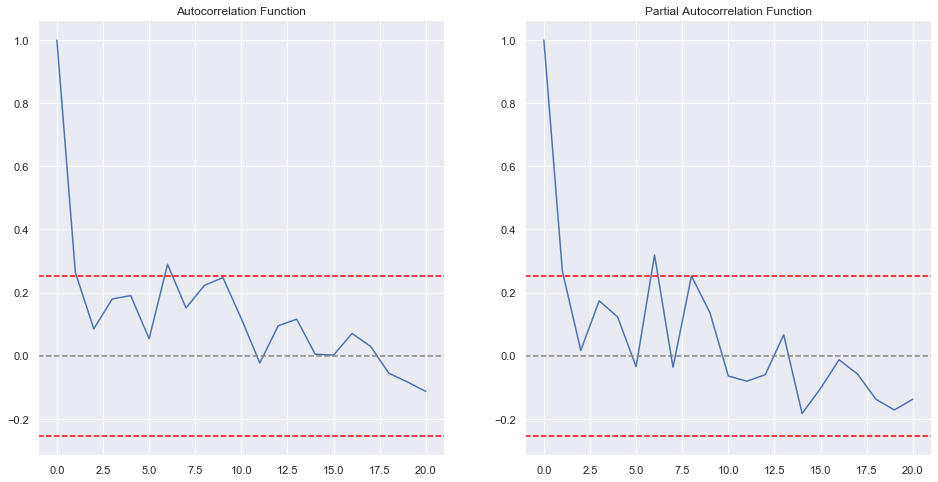

In [160]:
# MEX Data
lag_acf, lag_pacf, crit_value = calculate_acf_pacf(tfp_mex_df_ts, 20)
plot_acf_pacf(lag_acf, lag_pacf,crit_value)

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


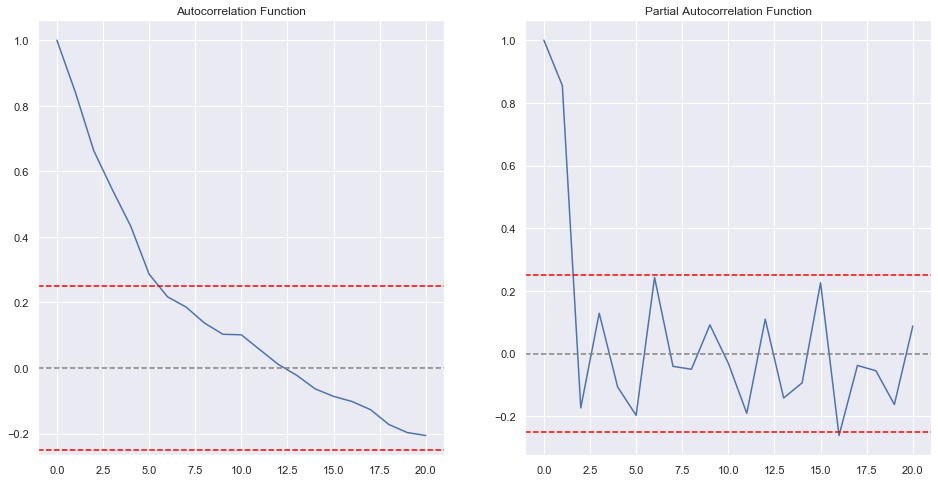

In [162]:
# Canada Data
lag_acf, lag_pacf, crit_value = calculate_acf_pacf(tfp_can_df, 20)
plot_acf_pacf(lag_acf, lag_pacf,crit_value)

From theory, we know that Q is equal to x where the line touches y=0 for the first time in the acf plot, while P is the x where the line touches y=0 for the first time in the pacf plot. Hence:

*   **USA**:Q = 2 ; P = 2
*   **MEXICO**: Q = 11, P = 5
*   **CANADA**: Q = 12, P = 2

In [166]:
# Define P and Q for each dataset:
# (Q,P) ordered like: USA, MEX, CAN 

q_p_list = [2,2,11,5,12,2]


#### Building Models

In [376]:
# list to store results

rss_results = []

*   **AutoRegressive Models**

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


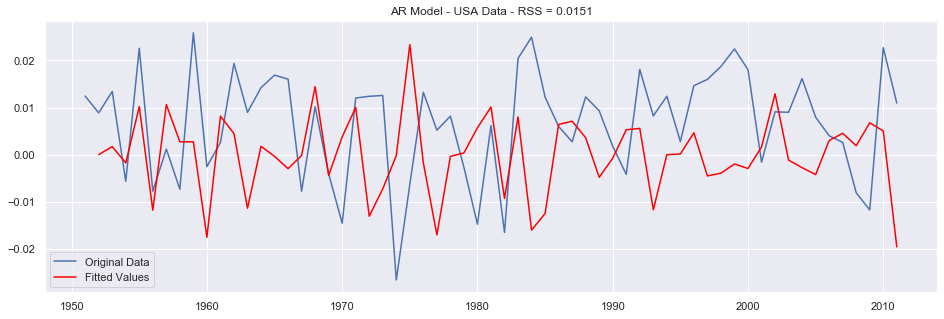

In [377]:
# AR Model - USA Data

'''
Model Parameters:
[AR] - q = 2
[I] - d = 1
[MA] - p = 0 
'''
#Model Definition
ar_model_usa = ARIMA(tfp_usa_df_ts, order=(2,1,0))
#Fit Data
result_ar_usa = ar_model_usa.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_usa_df_ts, label='Original Data');
plt.plot(result_ar_usa.fittedvalues, color='red', label='Fitted Values');
rss_ar_usa = sum((result_ar_usa.fittedvalues - tfp_usa_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_ar_usa)
plt.title('AR Model - USA Data - RSS = %.4f'%rss_ar_usa);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


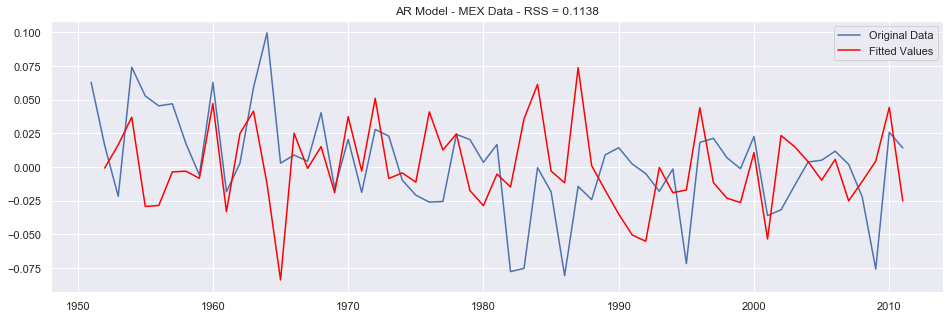

In [378]:
# AR Model - MEX Data

'''
Model Parameters:
[AR] - q = 11
[I] - d = 1
[MA] - p = 0 
'''
#Model Definition
ar_model_mex = ARIMA(tfp_mex_df_ts, order=(11,1,0))
#Fit Data
result_ar_mex = ar_model_mex.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_mex_df_ts, label='Original Data');
plt.plot(result_ar_mex.fittedvalues, color='red', label='Fitted Values');
rss_ar_mex = sum((result_ar_mex.fittedvalues - tfp_mex_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_ar_mex)
plt.title('AR Model - MEX Data - RSS = %.4f'%rss_ar_mex);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


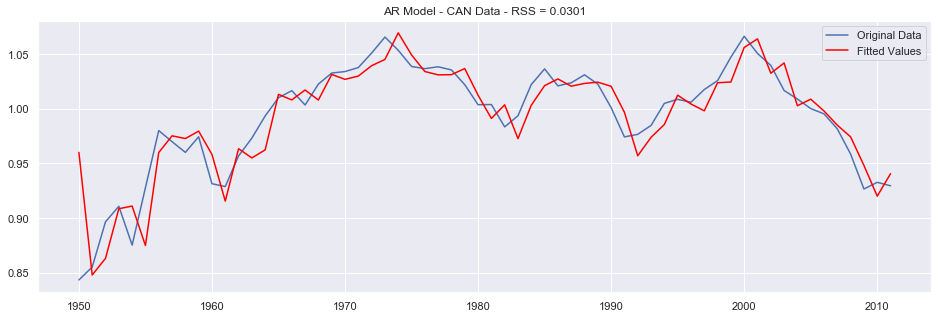

In [379]:
# AR Model - CAN Data

'''
Model Parameters:
[AR] - q = 12
[I] - d = 0
[MA] - p = 0 
'''
#Model Definition
ar_model_can = ARIMA(tfp_can_df, order=(12,0,0))
#Fit Data
result_ar_can = ar_model_can.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_can_df, label='Original Data');
plt.plot(result_ar_can.fittedvalues, color='red', label='Fitted Values');
rss_ar_can = sum((result_ar_can.fittedvalues - tfp_can_df['rtfpna'])**2);
rss_results.append(rss_ar_can)
plt.title('AR Model - CAN Data - RSS = %.4f'%rss_ar_can);
plt.legend();

*   **Moving Average Models**

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


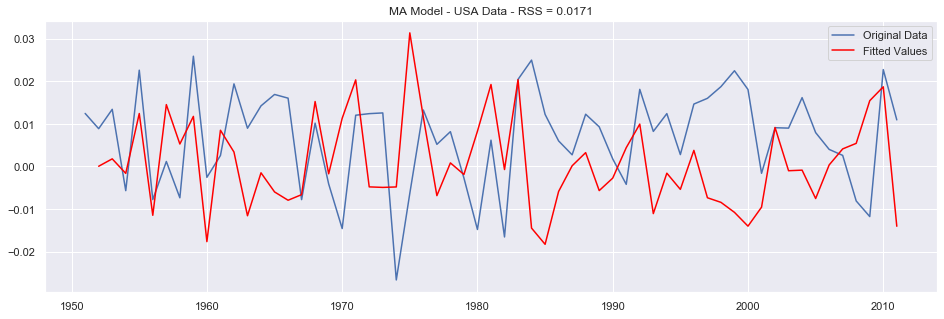

In [380]:
# MA Model - USA Data

'''
Model Parameters:
[AR] - q = 0
[I] - d = 1
[MA] - p = 2
'''
#Model Definition
ma_model_usa = ARIMA(tfp_usa_df_ts, order=(0,1,2))
#Fit Data
result_ma_usa = ma_model_usa.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_usa_df_ts, label='Original Data');
plt.plot(result_ma_usa.fittedvalues, color='red', label='Fitted Values');
rss_ma_usa = sum((result_ma_usa.fittedvalues - tfp_usa_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_ma_usa)
plt.title('MA Model - USA Data - RSS = %.4f'%rss_ma_usa);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


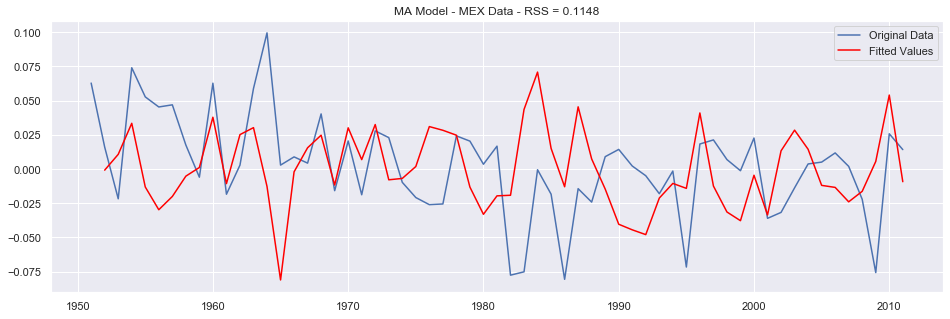

In [381]:
# MA Model - MEX Data

'''
Model Parameters:
[AR] - q = 0
[I] - d = 1
[MA] - p = 5
'''
#Model Definition
ma_model_mex = ARIMA(tfp_mex_df_ts, order=(0,1,5))
#Fit Data
result_ma_mex = ma_model_mex.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_mex_df_ts, label='Original Data');
plt.plot(result_ma_mex.fittedvalues, color='red', label='Fitted Values');
rss_ma_mex = sum((result_ma_mex.fittedvalues - tfp_mex_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_ma_mex)
plt.title('MA Model - MEX Data - RSS = %.4f'%rss_ma_mex);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


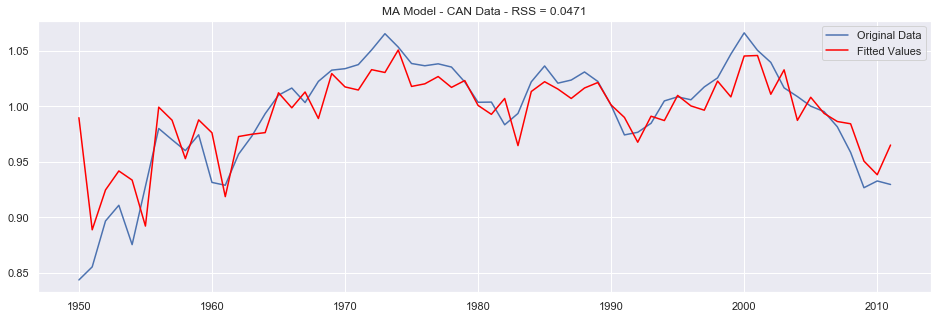

In [382]:
# MA Model - CAN Data

'''
Model Parameters:
[AR] - q = 0
[I] - d = 0
[MA] - p = 2
'''
#Model Definition
ma_model_can = ARIMA(tfp_can_df, order=(0,0,2))
#Fit Data
result_ma_can = ma_model_can.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_can_df, label='Original Data');
plt.plot(result_ma_can.fittedvalues, color='red', label='Fitted Values');
rss_ma_can = sum((result_ma_can.fittedvalues - tfp_can_df['rtfpna'])**2);
rss_results.append(rss_ma_can)
plt.title('MA Model - CAN Data - RSS = %.4f'%rss_ma_can);
plt.legend();

*   **AutoRegressive +  Integrated + Moving Average Models**

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


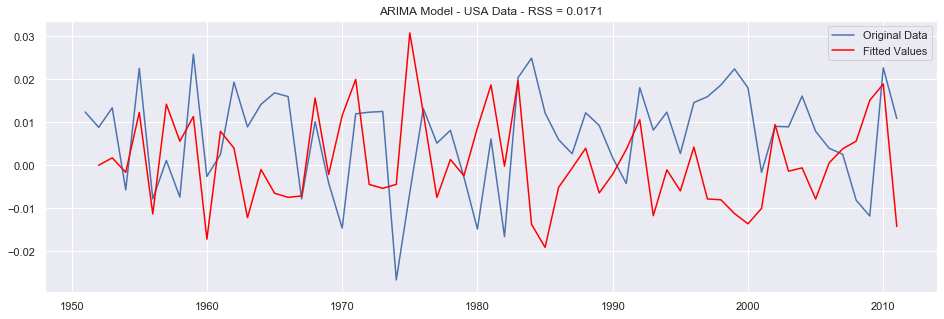

In [383]:
# ARIMA Model - USA Data

'''
Model Parameters:
[AR] - q = 2
[I] - d = 1
[MA] - p = 2
'''
#Model Definition
arima_model_usa = ARIMA(tfp_usa_df_ts, order=(2,1,2))
#Fit Data
result_arima_usa = arima_model_usa.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_usa_df_ts, label='Original Data');
plt.plot(result_arima_usa.fittedvalues, color='red', label='Fitted Values');
rss_arima_usa = sum((result_arima_usa.fittedvalues - tfp_usa_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_arima_usa)
plt.title('ARIMA Model - USA Data - RSS = %.4f'%rss_arima_usa);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


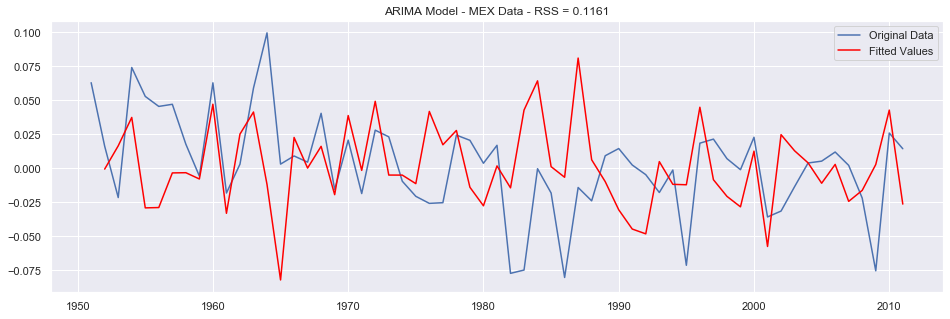

In [384]:
# AR Model - MEX Data

'''
Model Parameters:
[AR] - q = 12
[I] - d = 1
[MA] - p = 2

--- OBS --- values found during ACF and PACF (11,1,5) wouldn't work since MA coefficient was not invertable --
I just tried some values close to the original ones and have chosen the best result according to the metric that
has been used so far (RSS) ---
'''
#Model Definition
arima_model_mex = ARIMA(tfp_mex_df_ts, order=(12,1,2))
#Fit Data
result_arima_mex = arima_model_mex.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_mex_df_ts, label='Original Data');
plt.plot(result_arima_mex.fittedvalues, color='red', label='Fitted Values');
rss_arima_mex = sum((result_arima_mex.fittedvalues - tfp_mex_df_ts['rtfpna'][1:])**2);
rss_results.append(rss_arima_mex)
plt.title('ARIMA Model - MEX Data - RSS = %.4f'%rss_arima_mex);
plt.legend();

C:\Users\rpdie\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


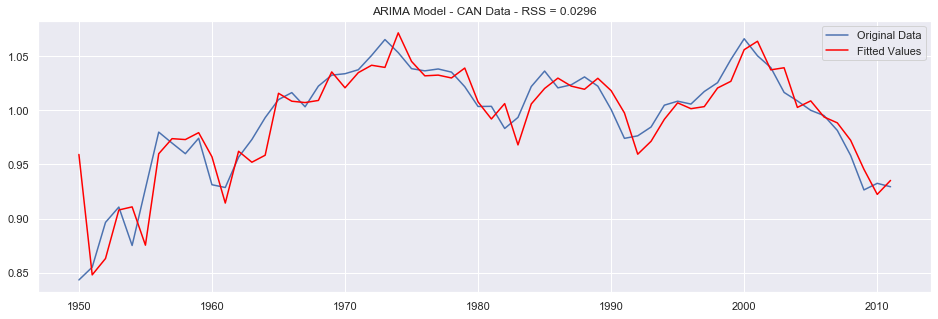

In [385]:
# ARIMA Model - CAN Data

'''
Model Parameters:
[AR] - q = 12
[I] - d = 0
[MA] - p = 2
'''
#Model Definition
arima_model_can = ARIMA(tfp_can_df, order=(12,0,2))
#Fit Data
result_arima_can = arima_model_can.fit(disp=-1)
#Plot and Store Results
plt.figure(figsize = (16,5));
plt.plot(tfp_can_df, label='Original Data');
plt.plot(result_arima_can.fittedvalues, color='red', label='Fitted Values');
rss_arima_can = sum((result_arima_can.fittedvalues - tfp_can_df['rtfpna'])**2);
rss_results.append(rss_arima_can)
plt.title('ARIMA Model - CAN Data - RSS = %.4f'%rss_arima_can);
plt.legend();

*   **Evaluating the Models**

In [386]:
def print_results(iso, pos):
    '''
    
    '''
    results = [rss_results[pos], rss_results[pos + 3], rss_results[pos + 6]] 
    
    print('Models Results - {}: \n'.format(iso))
    print('AR Model : {:.6f}'.format(results[0]))
    print('MA Model : {:.6f}'.format(results[1]))
    print('ARIMA Model : {:.6f}'.format(results[2]))
    
       
    best_rss = min(results)
   
    print('Best RSS: {:.6f}'.format(best_rss)) 
    

In [387]:
# USA Results

print_results('USA', 0)

Models Results - USA: 

AR Model : 0.015119
MA Model : 0.017119
ARIMA Model : 0.017091
Best RSS: 0.015119


In [388]:
# MEX Results

print_results('MEX', 1)

Models Results - MEX: 

AR Model : 0.113834
MA Model : 0.114752
ARIMA Model : 0.116060
Best RSS: 0.113834


In [389]:
# CAN Results

print_results('CAN', 2)

Models Results - CAN: 

AR Model : 0.030055
MA Model : 0.047141
ARIMA Model : 0.029644
Best RSS: 0.029644


According to the chosen metric (Residual Sum of Squares - RSS), we have the following:
*   **USA**: AutoRegressive model had the best fit for the given data;
*   **MEXICO**: AutoRegressive model had the best fit for the given data;
*   **CANADA**: AutoRegressive + Moving Average had the best fit for the given data;

**obs** - Results for the Mexican data are way worse than the other datasets - it would worth checking some other models for this dataset;

##### Making predictions

*   **USA**

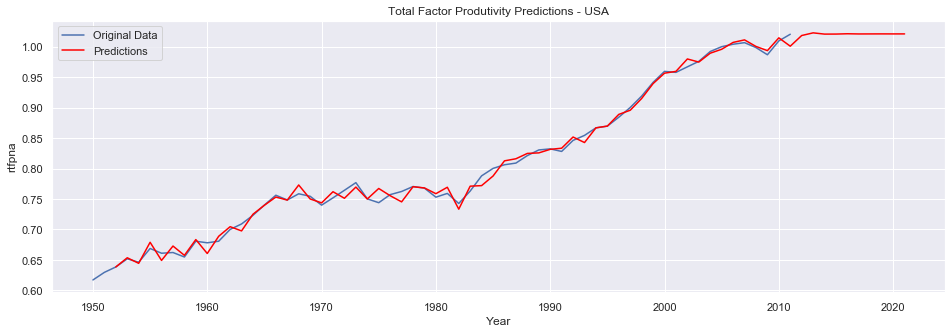

In [526]:
'''
 ===== Reverse Time-Shift Transformation: ====

Time Shift: Time difference = X[t] - X[t-1]

Revense Operation : X[t] = Predicted difference + X[t-1]

'''
#Reverse Time-Shift
predict_USA_past = result_ar_usa.fittedvalues + tfp_usa_df['rtfpna'][1:]
#Predict difference for 10 years
predict_USA_future_ts = result_ar_usa.predict(1, (len(predict_USA_past)+9))[-10:]
#Reverse Time-Shift for the Predictions
for i in range(len(predict_USA_future_ts)):
    if i == 0:
        pred = tfp_usa_df['rtfpna'][-1] + predict_USA_future_ts[i]
        predict_USA_future_ts[i] = pred
    else:
        pred = predict_USA_future_ts[i] + predict_USA_future_ts[i-1]
        predict_USA_future_ts[i] = pred
        
predictions_usa = pd.concat([predict_USA_past,predict_USA_future_ts])

# Plot Results
plt.figure(figsize = (16,5));
plt.plot(tfp_usa_df, label='Original Data');
plt.plot(predictions_usa, color='red', label='Predictions');
plt.legend();
plt.title('Total Factor Produtivity Predictions - USA');
plt.xlabel('Year');
plt.ylabel('rtfpna');


*   **MEXICO**

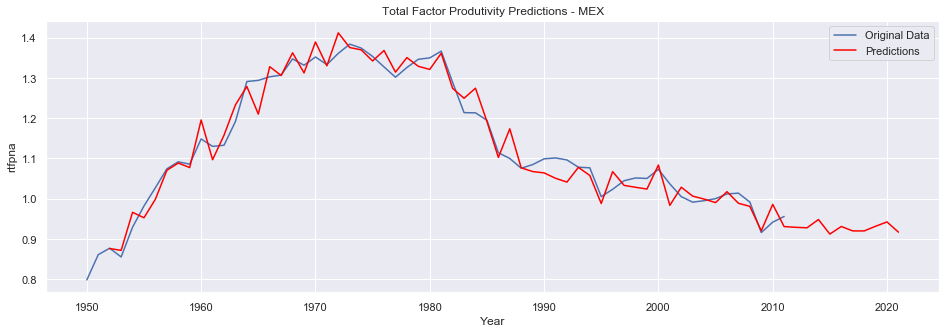

In [527]:
'''
 ===== Reverse Time-Shift Transformation: ====

Time Shift: Time difference = X[t] - X[t-1]

Revense Operation : X[t] = Predicted difference + X[t-1]

'''
#Reverse Time-Shift
predict_MEX_past = result_ar_mex.fittedvalues + tfp_mex_df['rtfpna'][1:]
#Predict difference for 10 years
predict_MEX_future_ts = result_ar_mex.predict(1, (len(predict_MEX_past)+9))[-10:]
#Reverse Time-Shift for the Predictions
for i in range(len(predict_MEX_future_ts)):
    if i == 0:
        pred = tfp_mex_df['rtfpna'][-1] + predict_MEX_future_ts[i]
        predict_MEX_future_ts[i] = pred
    else:
        pred = predict_MEX_future_ts[i] + predict_MEX_future_ts[i-1]
        predict_MEX_future_ts[i] = pred
        
predictions_mex = pd.concat([predict_MEX_past,predict_MEX_future_ts])

# Plot Results
plt.figure(figsize = (16,5));
plt.plot(tfp_mex_df, label='Original Data');
plt.plot(predictions_mex, color='red', label='Predictions');
plt.legend();
plt.title('Total Factor Produtivity Predictions - MEX');
plt.xlabel('Year');
plt.ylabel('rtfpna');

*   **Canada**

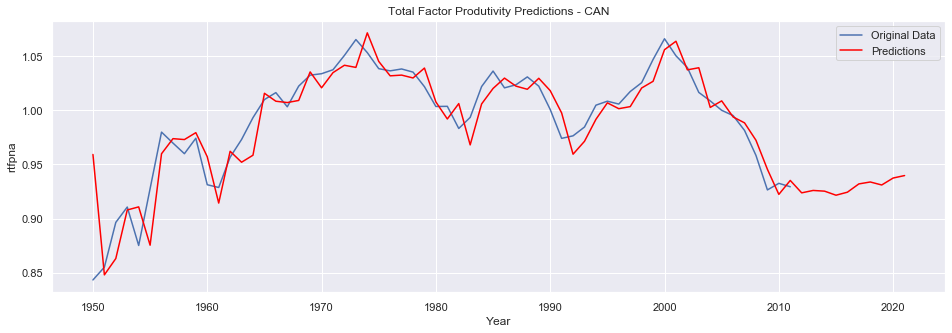

In [528]:
'''
No need of reverse operation on Canada's data

'''
#Reverse Time-Shift
predict_CAN_past = result_arima_can.fittedvalues
#Predict difference for 10 years
predict_CAN_future = result_arima_can.predict(1, (len(predict_CAN_past)+9))[-10:]
       
predictions_can = pd.concat([predict_CAN_past,predict_CAN_future])

# Plot Results
plt.figure(figsize = (16,5));
plt.plot(tfp_can_df, label='Original Data');
plt.plot(predictions_can, color='red', label='Predictions');
plt.legend();
plt.title('Total Factor Produtivity Predictions - CAN');
plt.xlabel('Year');
plt.ylabel('rtfpna');

### Which other feature could be helpful explaining TFP series?

Given the Aggregate Production Function, which is the mathematical model that ties the factors of production in a economy to the aggregate output of this econony:

Y = A*f(K,L)

where,

**Y** = Aggregate Output;

**A** = Technology factor (Total Factor Productivity);

**K** = Non-human capital;

**L** = Human capital;

I believe that the following features from the original dataset could be helpful in explaining the TFP series:

*   **emp** Number of persons engaged (in millions);
*   **avh** *Average annual hours worked by persons engaged;*
*   **hc** *Index of human capital per person, based on years of schooling (Barro and Lee 2013) and returns to education (Psacharopoulos 1994);*
*   **rgdpna** *Real GDP at constant 2005 national prices (in million 2005 USD);*
*   **rkna** *Capital stock at constant 2005 national prices (in million 2005 USD);*

As, **emp**, **avh** and **hc** could compose the "L" factor, **rgdpna** is the "Y" factor and **rkna** the "K" factor.

Hence, it would be possible to use a model approach to have a calculated version of FTP or even use the factors by itself to generate some more information for the predictions.